# Assignment 1
## I. Task Description

<div style="text-align: justify">

Construct a predictive model to predict the target.

The test set does not contain the target, so you will need to split up the train set accordingly into your own validation set. The test set supplied here is used to rank and assess your model on the competition leaderboard
Your model will be evaluated as follows: for the top-250 cases predicted by your model, we count the number of hits (true positives), i.e. precision@250. We focus on the top-250 only as there's only a limited amount of time and resources to investigate risky customers. AUC is also shown on the leaderboard for informational purposes
There are more than 500 churners present in the test set, though note that only 50% of the test set is used for the public leaderboard
The large degree of class imbalance, the way how the target was defined, the way how your model is evaluated, and possibilities for feature engineering will make for challenges to overcome
Instructions:

The goal is not to "win", but to help you reflect on your model's results, see how others are doing, etc.
The leaderboard is based on the number of true positives in the top-250 cases. The results of your latest submission are used to rank
This means it is your job to keep track of different model versions / approaches / outputs in case you'd like to go back to an earlier result
The "public" leaderboard calculates your score for a predetermined set 50% of the instances in the test set
Later on, the leaderboard will be frozen (you'll be warned in advance) and the other 50% results (hidden leaderboard) will be shown
You should then reflect on both results and explain accordingly in your report. E.g. if you did well on the public leaderboard but not on the hidden one, what might have caused this?
Also take some time the reflect on the score measure being used here. Is the the measure you'd have chosen in this setting? How does the score compare to the AUC of your model?
Reflect on the features and target definition. What would you change? How would your model be able to do better? Do you agree with the way the target was established or not?
Your model needs to be build using R, Python (or Julia, if you so prefer). As an environment, you can use e.g. Jupyter (Notebook or Lab), RStudio, Google Colaboratory, Microsoft Azure Machine Learning Studio... and any additional library or package you want
The first part of your lab report should contain a clear overview of your whole modeling pipeline, including approach, exploratory analysis (if any), preprocessing, construction of model, set-up of validation and results of the model:

Feel free to include code fragments, tables, visualisations, etc.
You can use any predictive technique/approach you want. The focus is not on the absolute outcome, but rather on the whole process: general setup, critical thinking, and the ability to get and validate an outcome
You're free to use unsupervised technique for your data exploration part, too. When you decide to build a black box model, including some interpretability techniques to explain it is a plus
Any other assumptions or insights are thoughts can be included as well: the idea is to take what we've seen in class, get your hands dirty and reflect on what we've seen
Important: All groups should submit the results of their predictive model at least once to the leaderboard.

</div>


## II. Features 

Features:

client_id: unique identifier per customer (anonymized hash); not to be used as a feature 

homebanking_active: whether the customer used / logged into home banking (Internet or Mobile app) this month

has_homebanking: whether the customer has activated home banking (Internet of Mobile app)

has_insurance_21: whether the customer owns "tak 21" life insurance products

has_insurance_23: whether the customer owns "tak 23" life insurance products

has_life_insurance_fixed_cap: whether the customer owns life insurance with fixed capital

has_life_insurance_decreasing_cap: whether the customer owns life insurance with decreasing capital

has_fire_car_other_insurance: whether the customer has fire/car/other insurance

has_personal_loan: whether the customer has an outstanding personal loan

has_mortgage_loan: whether the customer has an outstanding mortgage loan

has_current_account: whether the customer has a current (checkings) account

has_pension_saving: whether the customer has a pension (retirement) savings account

has_savings_account: whether the customer has a savings account

has_current_account_starter: whether the customer has a "starter" (a product offering some discounts and typically offered to new or younger customers) current (checkings) account

has_savings_account_starter: whether the customer has a "starter" (a product offering some discounts and typically offered to new or younger customers) savings account

bal_insurance_21: balance on "tak 21" life insurance

bal_insurance_23: balance on "tak 23" life insurance

cap_life_insurance_fixed_cap: capital for life insurance with fixed capital

cap_life_insurance_decreasing_cap: capital for life insurance with decreasing capital

prem_fire_car_other_insurance: premiums paid for fire/car/other insurance

bal_personal_loan: outstanding balance on personal loans

bal_mortgage_loan: outstanding balance on mortgage loans

bal_current_account: balance on current (checkings) accounts

bal_pension_saving: balance on pension (retirement) savings accounts

bal_savings_account: balance on savings accounts

bal_current_account_starter: balance on starter current (checkings) accounts

bal_savings_account_starter: balance on starter savings accounts

visits_distinct_so: how many different sales offices were visited in the past month by this customer (number of visits per office is not available)

visits_distinct_so_areas: how many different sales office areas were visited in the past month by this customer

customer_since_all: since when has the customer been a client for either bank or insurance products (YYYY-MM)

customer_since_bank: since when has the customer been a client for bank products (YYYY-MM)

customer_gender: gender code

customer_birth_date: date of birth (YYYY-MM)

customer_postal_code: postal code where the customer lives

customer_occupation_code: occupation (job) code

customer_self_employed: whether the customer is self-employed

customer_education: code of education level

customer_children: this describes family situation: either no children (no), one baby or toddler (onebaby), preschool child(ren) (preschool), children in secondary school (young), children in high school (adolescent), children between 18-24 (mature), children older than 24 (grownup), or children but without further details (yes)

customer_relationship: this describes the marital situation: single (single), living together or married (couple). Note that divorced persons and widowers are also indicated as single

target: target (1 or 0)


Monetary values were rounded at tens of euros. Extremely affluent customers or customers with large negative balances were not included. Missing values are represented as "NA". Given the real-life nature of the data set, expect other data quality issues as well.


## III. Data Analysis
#### 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import sklearn.model_selection as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

#### 2. Load Data Files

In [2]:
# test files
test_month_1 = pd.read_csv('data/test_month_1.csv')
test_month_2 = pd.read_csv('data/test_month_2.csv')
test_month_3 = pd.read_csv('data/test_month_3.csv')

# train files
train_month_1 = pd.read_csv('data/train_month_1.csv')
train_month_2 = pd.read_csv('data/train_month_2.csv')
train_month_3_with_target = pd.read_csv('data/train_month_3_with_target.csv')

original = train_month_3_with_target.copy()

#### 3. Clean Variables 

In [3]:
# convert the dates into days before 2018 
train_month_3_with_target["customer_since_all"] = (pd.to_datetime("2018-01") - pd.to_datetime(train_month_3_with_target["customer_since_all"])).dt.days
train_month_3_with_target["customer_birth_date"] = (pd.to_datetime("2018-01") - pd.to_datetime(train_month_3_with_target["customer_birth_date"])).dt.days
train_month_3_with_target["customer_since_bank"] = (pd.to_datetime("2018-01") - pd.to_datetime(train_month_3_with_target["customer_since_bank"])).dt.days


In [4]:
# create dummies for the different categorical variables 

train_month_3_with_target = pd.DataFrame(pd.get_dummies(train_month_3_with_target, 
                                   columns = ["customer_education", "customer_occupation_code", "customer_children", "customer_relationship"], 
                                   dummy_na=True))




# maybe aggregate postal code into regions? dummies result in too many columns
# maybe coordinates or distances from major cities in Belgium? 
# remove postal code for first model 

train_month_3_with_target = train_month_3_with_target.drop(["customer_postal_code"], axis=1)
train_month_3_with_target = train_month_3_with_target.drop(["client_id"], axis=1)

train_month_3_with_target['customer_since_all_na'] = np.where(train_month_3_with_target.customer_since_all.notnull(), '0', '1')
train_month_3_with_target['customer_since_bank_na'] = np.where(train_month_3_with_target.customer_since_bank.notnull(), '0', '1')


In [5]:
# Train Test Split to prevent data pollution
y = train_month_3_with_target['target']
X = train_month_3_with_target.drop(['target'], axis = 1)
X_train, X_val, y_train, y_val = sk.train_test_split(X, y, test_size=0.3, stratify=y)

# create one complete set for testing purposes 
fortest = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)


#### 3. Exploratory Data Analysis

In [6]:
# take a look at missing values
miss_perc = pd.DataFrame()
missings = original[["customer_since_all", "customer_since_bank", "customer_occupation_code", "customer_education", 
                               "customer_children", "customer_relationship", "target"]].copy()

miss_perc["percentage_missing"] = missings.isna().sum(axis=0) / missings.shape[0]

miss_perc["total_missing"] =  missings.isna().sum(axis=0)
miss_perc["missing_on_positive"] = missings.loc[missings["target"] == 1].isna().sum(axis=0)

miss_perc["percentage_positive_missing"] = miss_perc["missing_on_positive"] / miss_perc["total_missing"]

miss_perc["ratio"] = miss_perc["percentage_positive_missing"] / miss_perc["percentage_missing"]

miss_perc = miss_perc[["percentage_missing", "percentage_positive_missing", "ratio"]]

# apparantly the customer_since... variables have comparatively a lot of NAs when our target variable is positive
# We seemingly have almost always very personal information like education, children and relationship about positives
# seems illogical to me => churners are well known?? 

miss_perc[0:6]

,percentage_missing,percentage_positive_missing,ratio
customer_since_all,0.003674,0.051282,13.959456
customer_since_bank,0.003909,0.056225,14.382962
customer_occupation_code,0.031430,0.038462,1.223719
customer_education,0.739831,0.018992,0.025671
customer_children,0.366799,0.028805,0.078531
customer_relationship,0.233904,0.029935,0.127979


#### 4. Descriptives 

In [7]:

# distribution of target variable
print(fortest["target"].sum() / fortest.shape[0])

# summary stats of numerical variables 
# only children and relationship are categorical 
fortest.describe()

# summary stats of children and relationship


# plot some histograms 

# remove the ids and target or reveiling variables for modeling

0.030031175006167716


,homebanking_active,has_homebanking,has_insurance_21,has_insurance_23,has_life_insurance_fixed_cap,has_life_insurance_decreasing_cap,has_fire_car_other_insurance,has_personal_loan,has_mortgage_loan,has_current_account,...,customer_children_no,customer_children_onebaby,customer_children_preschool,customer_children_yes,customer_children_young,customer_children_nan,customer_relationship_couple,customer_relationship_single,customer_relationship_nan,target
count,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,...,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000
mean,0.214592,0.280956,0.095858,0.009936,0.002871,0.111714,0.318007,0.040348,0.097988,0.501469,...,0.360172,0.022204,0.036558,0.005091,0.041245,0.366654,0.568215,0.197412,0.234373,0.030031
std,0.410543,0.449471,0.294399,0.099182,0.053503,0.315018,0.465708,0.196776,0.297302,0.500003,...,0.480056,0.147347,0.187675,0.071171,0.198859,0.481896,0.495330,0.398050,0.423611,0.170675
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 5. Modeling

In [8]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)


In [9]:
# PCA

X = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y_train], axis = 1)

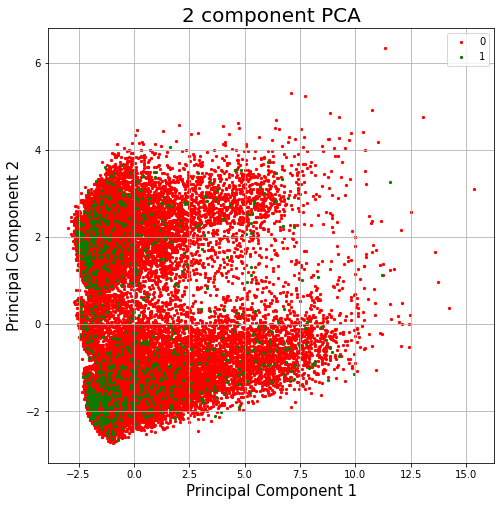

In [10]:
# plot the information 

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [ 0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 5)
ax.legend(targets)
ax.grid()